# **Development of StarNet**

> **Preamble:**  
> We develop **StarNet**, a supervised convolutional neural network model designed to predict stellar labels. The model is trained and evaluated on four datasets: synthetic JWST/NIRSpec, real APOGEE, synthetic Augmented JWST/NIRSpec, and synthetic Extended Mock JWST data. In all cases, StarNet achieves excellent precision and accuracy in predicting stellar labels.  
>
> *N.B.* In connection with the paper, datasets labeled in this code correspond to:
> - `JWST` (abbreviated `j`) → $\mathsf{J}$
> - `APOGEE` (abbreviated `a`) → $\mathsf{A}$
> - `Augmented JWST` (abbreviated `aug`) → $\mathcal{J}$
> - `Extended Mock JWST` (abbreviated `mock`) → $\mathcal{J}^{\text{hi}}$

## **Table of Contents**
* ### [0. Set Up](#set-up) ###
* ### [1. Process Data](#process-data) ###
  * #### [1.1. Load Data](#load-data) ####
  * #### [1.2. Prepare Data](#prep-data) ####
  * #### [1.3. Visualise Data](#vis-data) ####
  * #### [1.4. Partition Data](#partition-data) ####
  * #### [1.5. Summarise Data](#summarise-data) ####
* ### [2. Build Model](#build-model) ###
  * #### [2.1. Set up](#set-up-model) ####
  * #### [2.2. Create CNN](#create-CNN) ####
* ### [3. Train Model](#train-model) ###
  * #### [3.1. Set up](#set-up-train) ####
  * #### [3.2. Run training](#run-train) ####
  * #### [3.3. Plot losses & save models](#plot-save) #### 
* ### [4. Test Model](#test-model) ###
  * #### [4.1. Get test predictions](#get-test-preds) ####
  * #### [4.2. Plot residuals](#plot-residuals) ####
  * #### [4.3. Get metrics](#get-metrics) ####
* ### [5. References](#refs) ###

## **0. Set Up** <a class="anchor" id="set-up"></a>

In [1]:
## Import Packages ## 
# Standard Library 
import os
import json
import time
import gc
import copy
import random
from pathlib import Path

# Numerical Computing 
import numpy as np
import pandas as pd

# Visualization 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Astronomy
from astropy import constants, units
from astropy.io import fits

# Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch Ecosystem
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from torchsummary import summary

In [2]:
## Get the number of CPU cores available ##
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 72


In [3]:
## Get info about GPU ## 
!nvidia-smi

Fri Apr 18 13:14:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN Xp                Off |   00000000:04:00.0 Off |                  N/A |
| 23%   21C    P8              8W /  250W |     365MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
## Clear memory ## 
gc.collect()
torch.cuda.empty_cache()

In [5]:
## Set parameters for plotting ## 
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': 'gray',
    'grid.alpha': 0.4,
    'text.usetex': True,
    'font.family': 'serif'
})

# Set color map
cmap = sns.cubehelix_palette(8, start=2.8, rot=0.1, dark=0, light=0.95, as_cmap=True)

# Set label names
label_names = [
    r'$T_{\mathrm{eff}}$', r'$\log(g)$', r'[C/H]', r'[N/H]', r'[O/H]', r'[Na/H]', r'[Mg/H]', r'[Al/H]', r'[Si/H]', 
    r'[S/H]', r'[K/H]', r'[Ca/H]', r'[Ti/H]', r'[V/H]', r'[Cr/H]', r'[Mn/H]', r'[Fe/H]', r'[Co/H]', r'[Ni/H]', r'[Ce/H]'
]

In [6]:
## Set up seed for reproducibility ## 
def set_seed(seed):
    """
    Sets the random seed across multiple libraries to ensure reproducibility in experiments.

    This function fixes randomness in PyTorch, CUDA and NumPy, ensuring
    that results are consistent across multiple runs of the same code.

    Parameters:
    -----------
    seed : int
        The seed value to be used for random number generators.
    """
    torch.cuda.manual_seed(seed) # sets the seed for PyTorch's CUDA operations
    torch.backends.cudnn.deterministic = True # configures cuDNN to enforce deterministic computations
    torch.backends.cudnn.benchmark = False # disables cuDNN benchmarking to prevent non-deterministic behaviour
    np.random.seed(seed) # sets seed for NumPy’s random number generator.

set_seed(42)

## **1. Process Data** <a class="anchor" id="process-data"></a>

### **1.1. Load Data** <a class="anchor" id="load-data"></a>

In [7]:
## Define directories ## 
LOCAL_DATA_DIR = Path('DATA')

In [8]:
## Load in JWST files ## 
jwst_spec_file = LOCAL_DATA_DIR / 'JWST_APOGEE.h5'
jwst_wave = pd.read_hdf(jwst_spec_file, 'wavelength').iloc[0].values
jwst_labels = pd.read_hdf(jwst_spec_file, 'labels')
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra')

In [9]:
## Load in APOGEE files ## 
apogee_spec_file = LOCAL_DATA_DIR / 'apogee_dr17.h5'
apogee_labels = pd.read_hdf(apogee_spec_file, 'allstar')

In [10]:
## Load in Augmented JWST files ##
aug_jwst_labels = pd.read_pickle(LOCAL_DATA_DIR / "aug_jwst_labels.pkl")
aug_jwst_spectra = pd.read_pickle(LOCAL_DATA_DIR / "aug_jwst_spectra2.pkl")

with open(LOCAL_DATA_DIR / "split_indices.json", "r") as f:
    indices_dict = json.load(f)

aug_train_indices = np.array(indices_dict["train_indices"])
aug_val_indices = np.array(indices_dict["val_indices"])
aug_test_indices = np.array(indices_dict["test_indices"])

In [11]:
## Load extended mock JWST files ## 
extended_mock_jwst_labels = pd.read_pickle(LOCAL_DATA_DIR / "extended_mock_jwst_labels.pkl")
extended_mock_jwst_spectra = pd.read_pickle(LOCAL_DATA_DIR / "extended_mock_jwst_spectra5.pkl").reset_index(drop=True)

with open(LOCAL_DATA_DIR / "mock_split_indices.json", "r") as f:
    mock_indices_dict = json.load(f)

mock_train_indices = np.array(mock_indices_dict["mock_train_indices"])
mock_val_indices = np.array(mock_indices_dict["mock_val_indices"])
mock_test_indices = np.array(mock_indices_dict["mock_test_indices"])

### **1.2. Prepare Data** <a class="anchor" id="prep-data"></a>

In [12]:
## Convert JWST row names from stellar tags to indices ## 
jwst_spectra.reset_index(drop=True, inplace=True)
jwst_labels.reset_index(drop=True, inplace=True) 

In [13]:
## Drop missing data point in APOGEE data with no JWST pair ## 
apogee_labels.drop(index=11215, inplace=True)
apogee_labels.reset_index(drop=True, inplace=True)

print(apogee_labels.index)
print(f"Shapes of JWST and APOGEE labels before dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

## Drop all duplicates in APOGEE and JWST data ## 
duplicate_indices = apogee_labels[apogee_labels.duplicated(subset='APOGEE_ID', keep='first')].index
apogee_labels.drop(index=duplicate_indices, inplace=True)
jwst_spectra.drop(index=duplicate_indices, inplace=True) 
jwst_labels.drop(index=duplicate_indices, inplace=True)

apogee_labels.reset_index(drop=True, inplace=True)
jwst_spectra.reset_index(drop=True, inplace=True) 
jwst_labels.reset_index(drop=True, inplace=True)

print(f"Shapes of JWST and APOGEE labels after dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

RangeIndex(start=0, stop=19799, step=1)
Shapes of JWST and APOGEE labels before dropping duplicates: (19799, 20), (19799, 55)
Shapes of JWST and APOGEE labels after dropping duplicates: (19001, 20), (19001, 55)


In [14]:
## Calculate bounds for SNR ##
print(apogee_labels["SNR"].min(), apogee_labels["SNR"].max()) 

## Calculate error (ERR) of each stellar label ## 
# Select all error columns except M_H_ERR and ALPHA_M_ERR
err_columns = [col for col in apogee_labels.columns if col.endswith('_ERR') and col not in {'M_H_ERR', 'ALPHA_M_ERR'}]

# Apply error propagation (for metallicities) or unit conversion (for Teff) 
for col in err_columns:
    if col.endswith('FE_ERR'):
        # Propagate error: [X/H] = [X/Fe] + [Fe/H]
        apogee_labels[col] = np.sqrt(apogee_labels[col]**2 + apogee_labels['FE_H_ERR']**2)
    elif col == 'TEFF_ERR':
        # Convert from Kelvin to kilokelvin
        apogee_labels[col] /= 1000

# Compute mean error for each selected column
err_columns_mean = apogee_labels[err_columns].mean()
err_columns_mean

200.00645446777344 2943.144775390625


TEFF_ERR     0.006225
LOGG_ERR     0.024625
C_FE_ERR     0.015059
N_FE_ERR     0.016881
O_FE_ERR     0.014946
NA_FE_ERR    0.058193
MG_FE_ERR    0.015169
AL_FE_ERR    0.022134
SI_FE_ERR    0.016440
S_FE_ERR     0.043704
K_FE_ERR     0.039348
CA_FE_ERR    0.017324
TI_FE_ERR    0.020044
V_FE_ERR     0.058423
CR_FE_ERR    0.036914
MN_FE_ERR    0.018157
FE_H_ERR     0.008735
CO_FE_ERR    0.039559
NI_FE_ERR    0.015459
CE_FE_ERR    0.042324
dtype: float32

In [15]:
## Get APOGEE spectra data ## 
# The following block is included for completeness and reproducibility.
# It illustrates how the final APOGEE spectra were obtained from SDSS DR17
# but is not executed in the current pipeline, as we use a preprocessed version saved to disk.

# [EXTRACTION CODE BLOCK - COMMENTED OUT]

#start_time = time.time() 
#apogee_dr17_dir = Path('/yngve_data/') / 'sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec'
#apogee_spectra = [] 
#for i in apogee_labels.index: 
   # telescope = apogee_labels.loc[i, 'TELESCOPE'].decode("utf-8")
   # field = apogee_labels.loc[i, 'FIELD'].decode("utf-8")
   # file = apogee_labels.loc[i, 'FILE'].decode("utf-8")
   # file = f"aspcapStar-dr17-{apogee_labels.loc[i, 'APOGEE_ID'].decode('utf-8')}.fits"
   # path_to_spec = apogee_dr17_dir / telescope / field / file
   # hdul = fits.open(path_to_spec)
   # apogee_spec = hdul[1].data.astype(float)
   # apogee_spectra.append(apogee_spec)
   # hdul.close()
#end_time = time.time()

## Print elapsed time ##
#print(f"Elapsed time to download APOGEE spectra: {end_time - start_time:.2f} seconds")

## Save APOGEE spectra data as pickled file ## 
# _LOG10LAMBDA0 = 4.179
# _DLOG10LAMBDA = 6. * 10.**-6.
# _NLAMBDA = 8575
# apogee_wave = 10.**np.arange(
#     _LOG10LAMBDA0,
#     _LOG10LAMBDA0 +_NLAMBDA * _DLOG10LAMBDA,
#     _DLOG10LAMBDA
# )
#apogee_spectra = pd.DataFrame(apogee_spectra)
#apogee_spectra.columns = apogee_wave 
#apogee_spectra.to_pickle(os.path.join("DATA", "apogee_spectra.pkl"))

# Final spectra (aligned and resampled) are stored in 'DATA/apogee_spectra.pkl'
# and directly loaded into the model pipeline.

## Download APOGEE spectra data ## 
apogee_spectra = pd.read_pickle(LOCAL_DATA_DIR / "apogee_spectra.pkl")

## Print out shapes of APOGEE and JWST spectra data ##
print(f"Shape of APOGEE and JWST spectra: {apogee_spectra.shape}, {jwst_spectra.shape}")

Shape of APOGEE and JWST spectra: (19001, 8575), (19001, 8192)


In [16]:
## Drop unneeded APOGEE labels ## 
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_FE', '').capitalize())
apogee_labels = apogee_labels.iloc[:, 9:]  # drop first nine columns
apogee_labels = apogee_labels.loc[:, ~apogee_labels.columns.str.endswith('err')]
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('Logg', 'logg'))
apogee_labels = apogee_labels.drop(columns=["M_h", "Alpha_m", "Vmicro", "Vmacro"])
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_h', ''))

## Rescale Teff ## 
apogee_labels["Teff"] = apogee_labels["Teff"]/1000 
jwst_labels["Teff"] = jwst_labels["Teff"]/1000 

In [17]:
## Convert APOGEE metallicities [X/Fe] to JWST metallicities [X/H] ## 
# Note: [X/Fe] + [Fe/H] = [X/H].
Fe_H = apogee_labels["Fe"]
for i in range(2, len(apogee_labels.columns)):
    if i != apogee_labels.columns.get_loc('Fe'): # Fe column is already of the form [Fe/H] 
        apogee_labels.iloc[:, i] += Fe_H

## Check! ## 
all(jwst_labels == apogee_labels) == True

True

### **1.3. Visualise Data** <a class="anchor" id="vis-data"></a>

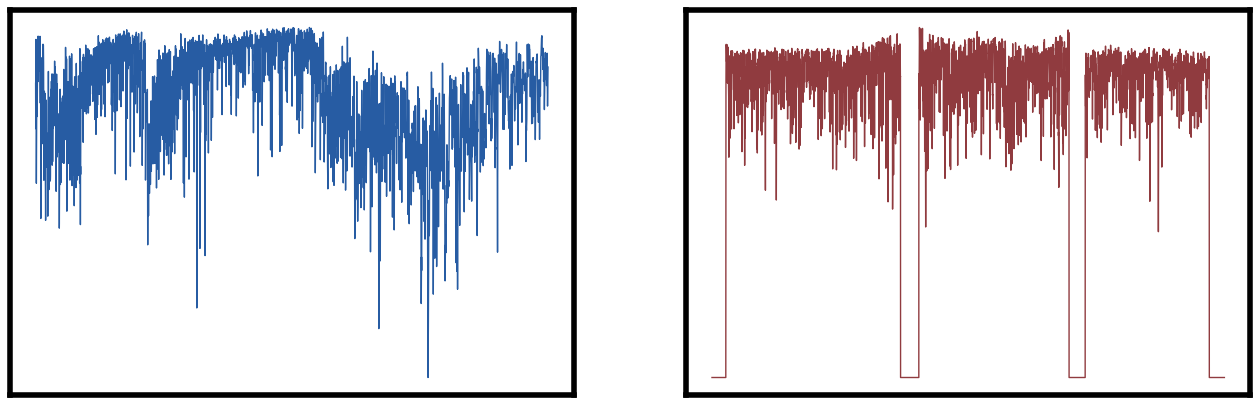

In [18]:
## Visualise sample JWST and APOGEE data ## 
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(jwst_spectra.iloc[0, :], linewidth=1, color='#275ca3')
plt.grid(False)
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xticks([])
plt.yticks([])

# Make the plot border thicker and darker
ax1 = plt.gca()
for spine in ax1.spines.values():
    spine.set_linewidth(4)  # Set border thickness
    spine.set_color('black')  # Set border color

plt.subplot(1, 2, 2)
plt.plot(apogee_spectra.iloc[0, :], linewidth=1, color='#903b3f')
plt.grid(False)
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xticks([])
plt.yticks([])

# Make the plot border thicker and darker
ax2 = plt.gca()
for spine in ax2.spines.values():
    spine.set_linewidth(4)  # Set border thickness
    spine.set_color('black')  # Set border color
    
plt.savefig(os.path.join("FIGURES", f"StarNet_example_data_plot.png"))
plt.show()

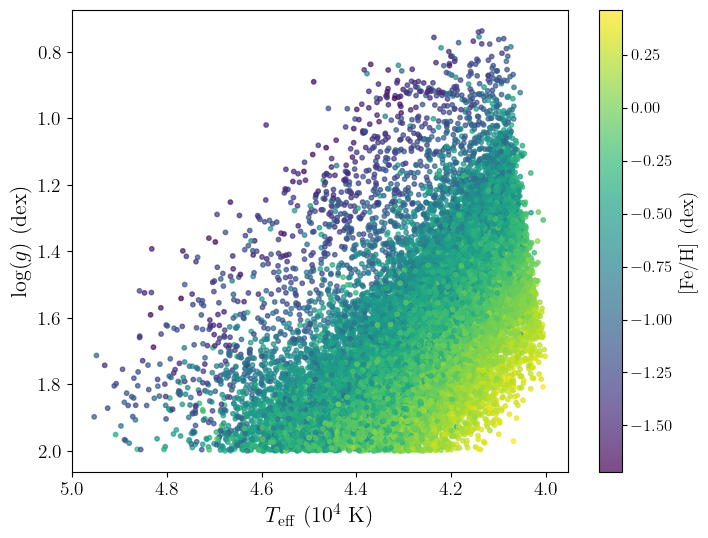

In [19]:
## Create a Kiel diagram for APOGEE data ##
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    apogee_labels['Teff'], 
    apogee_labels['logg'], 
    c=apogee_labels['Fe'], 
    cmap='viridis', 
    s=10, 
    alpha=0.7
)

cbar = plt.colorbar(scatter)
cbar.set_label('[Fe/H] (dex)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Reverse x-axis
plt.gca().invert_xaxis()
plt.gca().invert_yaxis() 

plt.xlabel(r'$T_{\mathrm{eff}}$ ($10^4$ K)', fontsize=16)
plt.ylabel(r'$\log(g)$ (dex)', fontsize=16)
plt.grid(False)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.savefig(os.path.join("FIGURES", f"StarNet_Kiel_diagram.png"), dpi=300)
plt.show()

### **1.4. Partition Data** <a class="anchor" id="partition-data"></a>

In [20]:
## Standardise data ## 
scaler = StandardScaler()
jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(jwst_labels), columns=jwst_labels.columns)
apogee_labels_scaled = pd.DataFrame(scaler.fit_transform(apogee_labels), columns=apogee_labels.columns)
aug_jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(aug_jwst_labels), columns=aug_jwst_labels.columns) 
extended_mock_jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(extended_mock_jwst_labels), columns=extended_mock_jwst_labels.columns) 

## Define denormalising function to undo StandardScaler ## 
def denormalize(scaler, labels_scaled):
    """
    Denormalises data scaled with StandardScaler. 

    Parameters:
    - scaler (StandardScaler): used to scale the data.
    - labels_scaled (pd.DataFrame): scaled data to be denormalised.

    Returns:
    - pd.DataFrame: data transformed back to its original scale. 
    """
    mean = scaler.mean_ 
    std = scaler.scale_
    return (labels_scaled * std) + mean

In [21]:
## Define inputs and outputs for JWST and APOGEE data ##
X_j = jwst_spectra.values
X_a = apogee_spectra.values

y_j = jwst_labels_scaled.values
y_a = apogee_labels_scaled.values

## Print shapes ##
print(f"Shapes of JWST inputs and outputs: {X_j.shape}, {y_j.shape}")
print(f"Shapes of APOGEE inputs and outputs: {X_a.shape}, {y_a.shape}")

Shapes of JWST inputs and outputs: (19001, 8192), (19001, 20)
Shapes of APOGEE inputs and outputs: (19001, 8575), (19001, 20)


In [22]:
## Create function to partition JWST and APOGEE data into train, val and test sets ## 
def train_val_test_split(X, y): 
    """
    Partitions data into training, validation, and test sets with a 5:1:2 ratio. 
    This function ensures reproducibility by setting a random seed.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.DataFrame): Target matrix.

    Returns:
    - X_train (pd.DataFrame): Training feature matrix.
    - X_val (pd.DataFrame): Validation feature matrix.
    - X_test (pd.DataFrame): Test feature matrix.
    - y_train (pd.DataFrame): Training target matrix.
    - y_val (pd.DataFrame): Validation target matrix.
    - y_test (pd.DataFrame): Test target matrix.
    """
    # First, split data into 75% train and 25% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/4, random_state = 42) 
    # Next, split train into 5/6 train and 1/6 validation 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/6, random_state = 42) 
    return X_train, X_val, X_test, y_train, y_val, y_test 

## Partition JWST and APOGEE data ## 
# JWST
X_j_train, X_j_val, X_j_test, y_j_train, y_j_val, y_j_test = train_val_test_split(X_j, y_j) 
# APOGEE 
X_a_train, X_a_val, X_a_test, y_a_train, y_a_val, y_a_test = train_val_test_split(X_a, y_a) 

## Print shapes ##
print(f"Shapes of JWST train, val, test sets: {X_j_train.shape}, {X_j_val.shape}, {X_j_test.shape}")
print(f"Shapes of APOGEE train, val, test sets: {X_a_train.shape}, {X_a_val.shape}, {X_a_test.shape}")

Shapes of JWST train, val, test sets: (11875, 8192), (2375, 8192), (4751, 8192)
Shapes of APOGEE train, val, test sets: (11875, 8575), (2375, 8575), (4751, 8575)


In [23]:
## Partition Augmented JWST and Extended Mock JWST data ##
# Aug 
X_aug_train = aug_jwst_spectra.iloc[aug_train_indices].values 
X_aug_val = aug_jwst_spectra.iloc[aug_val_indices].values 
X_aug_test = aug_jwst_spectra.iloc[aug_test_indices].values 

y_aug_train = aug_jwst_labels_scaled.iloc[aug_train_indices].values 
y_aug_val = aug_jwst_labels_scaled.iloc[aug_val_indices].values 
y_aug_test = aug_jwst_labels_scaled.iloc[aug_test_indices].values 

# Mock
X_mock_train = extended_mock_jwst_spectra.iloc[mock_train_indices].values
X_mock_val = extended_mock_jwst_spectra.iloc[mock_val_indices].values
X_mock_test = extended_mock_jwst_spectra.iloc[mock_test_indices].values

y_mock_train = extended_mock_jwst_labels_scaled.iloc[mock_train_indices].values
y_mock_val = extended_mock_jwst_labels_scaled.iloc[mock_val_indices].values
y_mock_test = extended_mock_jwst_labels_scaled.iloc[mock_test_indices].values

## Print shapes ## 
print(f"Shapes of Aug JWST train, val, test sets: {X_aug_train.shape}, {X_aug_val.shape}, {X_aug_test.shape}")
print(f"Shapes of Extended JWST train, val, test sets: {X_mock_train.shape}, {X_mock_val.shape}, {X_mock_test.shape}")

Shapes of Aug JWST train, val, test sets: (59375, 8192), (11875, 8192), (23755, 8192)
Shapes of Extended JWST train, val, test sets: (156, 8192), (31, 8192), (5063, 8192)


## **2. Build Model** <a class="anchor" id="build-model"></a>

### **2.1. Set up** <a class="anchor" id="set-up-model"></a>

In [24]:
## Define helper function ## 
def compute_out_size(in_size, mod):
    """
    Compute the output size of a PyTorch module `mod` given an input with size `in_size`.

    Args:
        in_size (tuple): The size of the input tensor (excluding batch size).
        mod (torch.nn.Module): The PyTorch module for which to compute the output size.

    Returns:
        tuple: The size of the output tensor (excluding batch size).
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

In [25]:
## Instantiate neural network parameters ## 
num_filters = [4, 16] # Number of filters used in convolutional layers
filter_length = 8 # Length of the filters in convolutional layers
pool_length = 4 # Length of maxpooling window 
num_hidden = [256, 128] # Number of nodes in each of hidden fully connected layers

num_jwst_labels = y_j_train.shape[1] # Number of JWST labels  
num_apogee_labels = y_a_train.shape[1] # Number of APOGEE labels 

num_jwst_fluxes = X_j_train.shape[1] # Number of JWST fluxes
num_apogee_fluxes = X_a_train.shape[1] # Number of APOGEE fluxes

### **2.2. Create CNN** <a class="anchor" id="create-CNN"></a>

In [26]:
## Define CNN ## 
class StarNet(nn.Module):
    def __init__(self, num_fluxes: int, num_filters: list, filter_length: int, pool_length: int, num_hidden: list, num_labels: int):
        super(StarNet, self).__init__()
        # Define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = num_filters[0], kernel_size = filter_length)
        self.conv2 = nn.Conv1d(in_channels = num_filters[0], out_channels = num_filters[1], kernel_size = filter_length)

        # Define pooling layer 
        self.pool = nn.AvgPool1d(pool_length, pool_length)

        # Compute shape after pooling
        pool_output_shape = compute_out_size((1,num_fluxes), nn.Sequential(self.conv1, self.conv2, self.pool))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features = pool_output_shape[0]*pool_output_shape[1], out_features = num_hidden[0])
        self.fc2 = nn.Linear(in_features = num_hidden[0], out_features = num_hidden[1])
        self.output = nn.Linear(in_features = num_hidden[1], out_features = num_labels)
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.output(x)
        return x

In [27]:
## Instantiate CNN Models ## 
set_seed(42) # for reproducibility
APOGEEModel = StarNet(num_apogee_fluxes, num_filters, filter_length, pool_length, num_hidden, num_apogee_labels)
JWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)
AugJWSTModel = copy.deepcopy(JWSTModel)
ExtendedMockJWSTModel = copy.deepcopy(JWSTModel)

## Move models to GPU ## 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Device is {device}")
APOGEEModel.to(device) 
JWSTModel.to(device) 
AugJWSTModel.to(device) 
ExtendedMockJWSTModel.to(device)

Device is cuda


StarNet(
  (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
  (pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=32704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=20, bias=True)
)

In [28]:
## Summarise CNN ## 
summary(APOGEEModel, (1, num_apogee_fluxes)) 
#summary(JWSTModel, (1, num_jwst_fluxes)) 
#summary(AugJWSTModel, (1, num_jwst_fluxes)) 
#summary(ExtendedJWSTModel, (1, num_jwst_fluxes)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 8568]              36
            Conv1d-2             [-1, 16, 8561]             528
         AvgPool1d-3             [-1, 16, 2140]               0
            Linear-4                  [-1, 256]       8,765,696
            Linear-5                  [-1, 128]          32,896
            Linear-6                   [-1, 20]           2,580
Total params: 8,801,736
Trainable params: 8,801,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.57
Params size (MB): 33.58
Estimated Total Size (MB): 35.18
----------------------------------------------------------------


## **3. Train Model** <a class="anchor" id="train-model"></a>

### **3.1. Set up** <a class="anchor" id="set-up-train"></a>

In [29]:
## Set training parameters ##
set_seed(42)
batch_size = 64
batch_size_val = 128
batch_size_test = 128
num_epochs = 15
learning_rate = 0.001

## Construct optimizers ##
APOGEEOptimizer = torch.optim.Adam(APOGEEModel.parameters(), lr=learning_rate, weight_decay=0)
JWSTOptimizer = torch.optim.Adam(JWSTModel.parameters(), lr=learning_rate, weight_decay=0)
AugJWSTOptimizer = torch.optim.Adam(AugJWSTModel.parameters(), lr=0.0005, weight_decay=0)
ExtendedMockJWSTOptimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, ExtendedMockJWSTModel.parameters()), 
    lr=0.001, weight_decay=5e-4
)

## Implement learning rate schedulers ## 
APOGEEScheduler = lr_scheduler.StepLR(APOGEEOptimizer, step_size=5, gamma=0.1)
JWSTScheduler = lr_scheduler.StepLR(JWSTOptimizer, step_size=5, gamma=0.1)
AugJWSTScheduler = lr_scheduler.StepLR(AugJWSTOptimizer, step_size=5, gamma=0.1)
ExtendedMockJWSTScheduler = lr_scheduler.StepLR(ExtendedMockJWSTOptimizer, step_size=5, gamma=0.1)

In [30]:
## Load in trained models ## 
def load_model(model, optimizer, model_name, device='cpu'):
    """
    Load model and optimizer states from the specified file path.

    Parameters:
    - model (torch.nn.Module): Initialized PyTorch model to load the state into.
    - optimizer (torch.optim.Optimizer): Corresponding optimizer.
    - model_name (str): Name identifier used when saving ("JWST", "APOGEE", etc.).
    - device (str): Device to load the model onto ('cpu' or 'cuda').

    Returns:
    - model: Model with loaded parameters.
    - optimizer: Optimizer with loaded parameters.
    """
    filepath = os.path.join("MODELS", f"StarNet_{model_name}.pth.tar")
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print(f"Loaded model and optimizer states from '{filepath}'.")
    
    return model, optimizer

# Load AugJWST model
AugJWSTModel, AugJWSTOptimizer = load_model(AugJWSTModel, AugJWSTOptimizer, "AugJWST")

Loaded model and optimizer states from 'MODELS/StarNet_AugJWST.pth.tar'.


In [31]:
## Initialize ExtendedMockJWSTModel with weights from AugJWSTModel ## 
# Get state dicts
aug_state_dict = AugJWSTModel.state_dict()
extended_state_dict = ExtendedMockJWSTModel.state_dict()

# Filter compatible parameters (by name and shape)
pretrained_dict = {
    k: v for k, v in aug_state_dict.items()
    if k in extended_state_dict and v.shape == extended_state_dict[k].shape
}

# Load matching weights
extended_state_dict.update(pretrained_dict)
ExtendedMockJWSTModel.load_state_dict(extended_state_dict)
print("ExtendedMockJWSTModel successfully initialized with pretrained AugJWSTModel weights.")

# Show which parameters were loaded
for key in pretrained_dict:
    print(f"Loaded parameter: {key}")

## Freeze specific layers ## 
layers_to_freeze = ['conv1', 'conv2']

for name, param in ExtendedMockJWSTModel.named_parameters():
    param.requires_grad = not any(layer in name for layer in layers_to_freeze)

# Show requires_grad status
for name, param in ExtendedMockJWSTModel.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

ExtendedMockJWSTModel successfully initialized with pretrained AugJWSTModel weights.
Loaded parameter: conv1.weight
Loaded parameter: conv1.bias
Loaded parameter: conv2.weight
Loaded parameter: conv2.bias
Loaded parameter: fc1.weight
Loaded parameter: fc1.bias
Loaded parameter: fc2.weight
Loaded parameter: fc2.bias
Loaded parameter: output.weight
Loaded parameter: output.bias
conv1.weight: requires_grad = False
conv1.bias: requires_grad = False
conv2.weight: requires_grad = False
conv2.bias: requires_grad = False
fc1.weight: requires_grad = True
fc1.bias: requires_grad = True
fc2.weight: requires_grad = True
fc2.bias: requires_grad = True
output.weight: requires_grad = True
output.bias: requires_grad = True


In [32]:
## Define function to create dataloaders ## 
def create_dataloader(X, y, batch_size, shuffle=True):
    """
    Creates a PyTorch DataLoader from input features and labels.
    
    Args:
    - X (array-like): The input features. 
    - y (array-like): The corresponding labels or target values. 
    - batch_size (int): The number of samples per batch to load.
    - shuffle (bool, optional): Whether to shuffle the data at every epoch. Default is True.

    Returns:
    - DataLoader: A DataLoader object that can be used to iterate over the dataset in batches.
    """ 
    set_seed(42) 
    tensor_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    return DataLoader(tensor_data, batch_size=batch_size, shuffle=shuffle)

## Convert train, val, test datasets to dataloaders ## 
# JWST 
train_j_dataloader = create_dataloader(X_j_train, y_j_train, batch_size)
val_j_dataloader = create_dataloader(X_j_val, y_j_val, batch_size_val, shuffle=False)
test_j_dataloader = create_dataloader(X_j_test, y_j_test, batch_size_test, shuffle=False)

# APOGEE 
train_a_dataloader = create_dataloader(X_a_train, y_a_train, batch_size)
val_a_dataloader = create_dataloader(X_a_val, y_a_val, batch_size_val, shuffle=False)
test_a_dataloader = create_dataloader(X_a_test, y_a_test, batch_size_test, shuffle=False)

# Augmented JWST
train_aug_dataloader = create_dataloader(X_aug_train, y_aug_train, batch_size)
val_aug_dataloader = create_dataloader(X_aug_val, y_aug_val, batch_size_val, shuffle=False)
test_aug_dataloader = create_dataloader(X_aug_test, y_aug_test, batch_size_test, shuffle=False)

# Extended Mock JWST 
train_mock_dataloader = create_dataloader(X_mock_train, y_mock_train, batch_size=16)
val_mock_dataloader = create_dataloader(X_mock_val, y_mock_val, batch_size=4, shuffle=False)
test_mock_dataloader = create_dataloader(X_mock_test, y_mock_test, batch_size=128, shuffle=False)

### **3.2. Run training** <a class="anchor" id="run-train"></a>

In [33]:
## Define funtion to train model ## 
def train_model(train_dataloader, val_dataloader, model, optimizer, scheduler, num_epochs=15, epsilon_tol=1e-3, N_stop=5, print_iters=200):
    """
    Trains a PyTorch model with optional early stopping based on validation loss improvement.

    Parameters:
    - train_dataloader (DataLoader): Training data loader.
    - val_dataloader (DataLoader): Validation data loader.
    - model (torch.nn.Module): Model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for model updates.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
    - num_epochs (int): Maximum number of epochs to train.
    - epsilon_tol (float): Minimum required improvement in validation loss to reset early stopping counter.
    - N_stop (int or None): Number of consecutive epochs without sufficient improvement before stopping. If None, early stopping is disabled.
    - print_iters (int): Number of iterations before printing training loss update.

    Returns:
    - train_losses (list): Training loss per epoch.
    - val_losses (list): Validation loss per epoch.
    """
    set_seed(42) 
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve_epochs = 0  # Counter for early stopping

    print("Begin training \n") 

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        model.train()

        # Training Loop
        for i, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(X_batch.unsqueeze(1).to(device))
            loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # Print statistics every 'print_iters' iterations
            if (i + 1) % print_iters == 0 or (i + 1) == len(train_dataloader):
                print(f'[Epoch {epoch + 1}, {(i + 1) / len(train_dataloader) * 100:.0f}%] '
                      f'Train Loss: {running_train_loss / (i + 1):.4f}', end="\r")
        
        train_loss = running_train_loss / len(train_dataloader)

        # Validation Loop
        running_val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                y_pred = model(X_batch.unsqueeze(1).to(device))
                loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))
                running_val_loss += loss.item()
        
        val_loss = running_val_loss / len(val_dataloader)
        
        print(f'[Epoch {epoch + 1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping Logic (if enabled)
        if N_stop is not None:
            if best_val_loss - val_loss >= epsilon_tol:
                best_val_loss = val_loss
                no_improve_epochs = 0  # Reset counter if improvement is significant
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= N_stop:
                print(f"Early stopping triggered after {epoch + 1} epochs. No improvement of at least {epsilon_tol} for {N_stop} consecutive epochs.")
                break  # Stop training

        # Step the scheduler
        scheduler.step()
    
    print("Finished Training \n")
    return train_losses, val_losses

## Train models with early stopping ##
# JWST
start_time = time.time()
train_j_losses, val_j_losses = train_model(
    train_j_dataloader, val_j_dataloader, JWSTModel,
    JWSTOptimizer, JWSTScheduler
)
print(f"JWST training time: {time.time() - start_time:.2f} seconds\n")

# APOGEE
start_time = time.time()
train_a_losses, val_a_losses = train_model(
    train_a_dataloader, val_a_dataloader, APOGEEModel,
    APOGEEOptimizer, APOGEEScheduler
)
print(f"APOGEE training time: {time.time() - start_time:.2f} seconds\n")

# Augmented JWST --> already pre-trained 
# start_time = time.time()
# train_aug_losses, val_aug_losses = train_model(
#     train_aug_dataloader, val_aug_dataloader, AugJWSTModel,
#     AugJWSTOptimizer, AugJWSTScheduler
# )
# print(f"Augmented JWST training time: {time.time() - start_time:.2f} seconds\n")

# Extended Mock JWST
start_time = time.time()
train_mock_losses, val_mock_losses = train_model(
    train_mock_dataloader, val_mock_dataloader, ExtendedMockJWSTModel,
    ExtendedMockJWSTOptimizer, ExtendedMockJWSTScheduler,
    num_epochs=30
)
print(f"Extended Mock JWST training time: {time.time() - start_time:.2f} seconds\n")

Begin training 

[Epoch 1] Train Loss: 0.9608, Val Loss: 0.3840, LR: 0.001000
[Epoch 2] Train Loss: 0.3176, Val Loss: 0.2541, LR: 0.001000
[Epoch 3] Train Loss: 0.2648, Val Loss: 0.2533, LR: 0.001000
[Epoch 4] Train Loss: 0.2117, Val Loss: 0.1706, LR: 0.001000
[Epoch 5] Train Loss: 0.1460, Val Loss: 0.1474, LR: 0.001000
[Epoch 6] Train Loss: 0.0941, Val Loss: 0.0847, LR: 0.000100
[Epoch 7] Train Loss: 0.0754, Val Loss: 0.0672, LR: 0.000100
[Epoch 8] Train Loss: 0.0607, Val Loss: 0.0592, LR: 0.000100
[Epoch 9] Train Loss: 0.0537, Val Loss: 0.0534, LR: 0.000100
[Epoch 10] Train Loss: 0.0509, Val Loss: 0.0538, LR: 0.000100
[Epoch 11] Train Loss: 0.0493, Val Loss: 0.0506, LR: 0.000010
[Epoch 12] Train Loss: 0.0489, Val Loss: 0.0506, LR: 0.000010
[Epoch 13] Train Loss: 0.0487, Val Loss: 0.0505, LR: 0.000010
[Epoch 14] Train Loss: 0.0486, Val Loss: 0.0503, LR: 0.000010
[Epoch 15] Train Loss: 0.0484, Val Loss: 0.0501, LR: 0.000010
Finished Training 

JWST training time: 32.99 seconds

Begin t

### **3.3. Plot losses & save models** <a class="anchor" id="plot-save"></a>

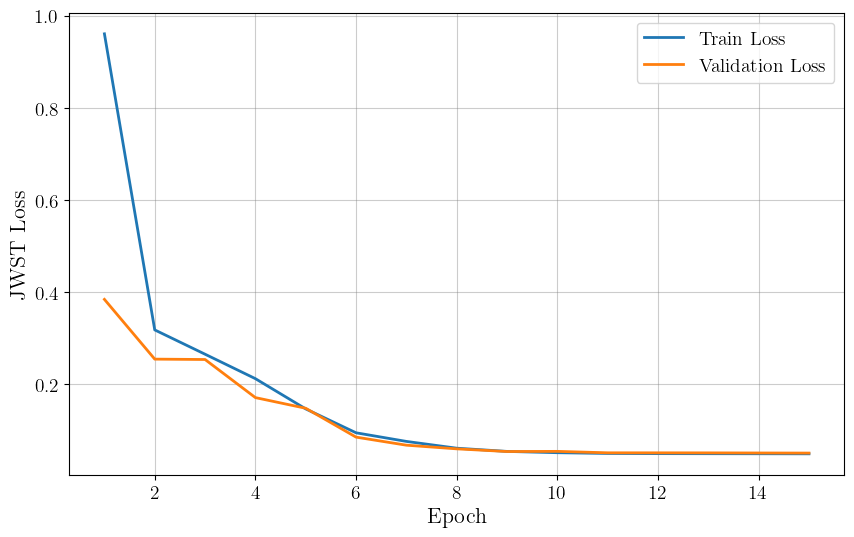

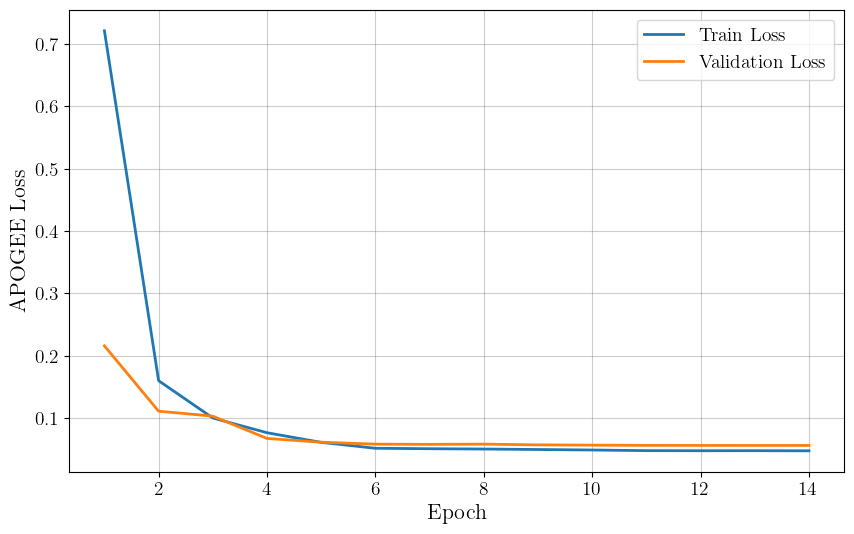

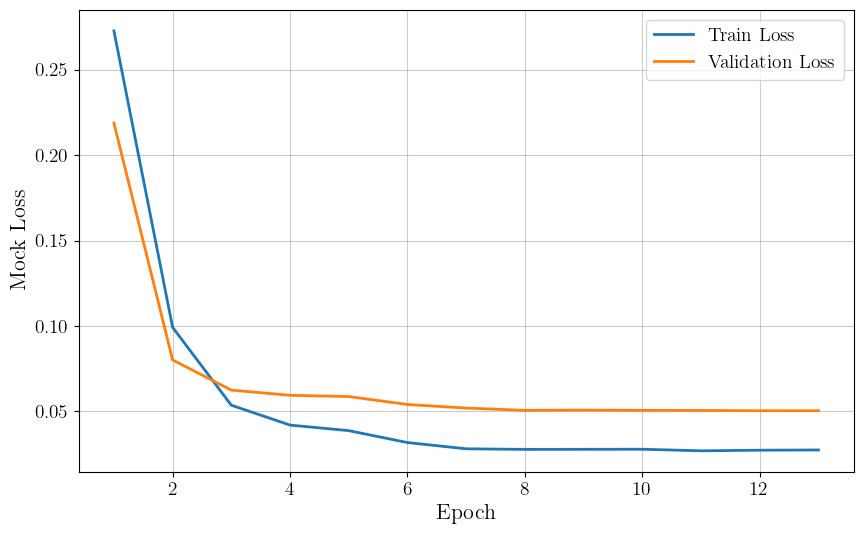

In [34]:
# ## Plot losses ## 
def plot_losses(train_losses, val_losses, model_name):
    """
    Plots training and validation losses over epochs. Save figure to "FIGURES" directory. 

    Args:
    - train_losses (list): contains training losses for each epoch.
    - val_losses (list): contains validation losses for each epoch.
    - model_name (str): 'APOGEE' or 'JWST'. 
    """
    num_epochs = len(train_losses)  # Match the actual trained epochs
    
    plt.figure(figsize=(10, 6))  
    plt.plot(range(1, num_epochs + 1), train_losses, label = "Train Loss", linewidth=2)
    plt.plot(range(1, num_epochs + 1), val_losses, label = "Validation Loss", linewidth=2)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(f"{model_name} Loss", fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    
    # Save the figure
    plt.savefig(os.path.join("FIGURES", f"StarNet_{model_name}_loss_plot.png"))
    plt.show()
    plt.close()

plot_losses(train_j_losses, val_j_losses, "JWST")
plot_losses(train_a_losses, val_a_losses, "APOGEE")
#plot_losses(train_aug_losses, val_aug_losses, "Augmented")
plot_losses(train_mock_losses, val_mock_losses, "Mock") 

In [ ]:
# ## Save models ## 
# def save_model(model, optimizer, model_name):
#     """
#     Save model and optimizer states to a specified file path.

#     Parameters:
#     - model (torch.nn.Module): PyTorch model to be saved.
#     - optimizer (torch.optim.Optimizer): PyTorch optimizer to be saved.
#     - model_name (str): 'APOGEE' or 'JWST'. 
#     """
#     torch.save({'optimizer' : optimizer.state_dict(),
#                 'model' : model.state_dict()}, 
#                os.path.join("MODELS", f"StarNet_{model_name}.pth.tar"))
#     print(f"Successfully saved {model_name}.")

# user_input = input("Type 'true' to save Model: ").strip().lower()
# if user_input == "true": 
#     save_model(JWSTModel, JWSTOptimizer, "JWST") 
#     save_model(APOGEEModel, APOGEEOptimizer, "APOGEE") 
#     save_model(AugJWSTModel, AugJWSTOptimizer, "AugJWST") 
#     save_model(ExtendedMockJWSTModel, ExtendedMockJWSTOptimizer, "ExtendedMockJWST")

## **4. Test Model** <a class="anchor" id="test-model"></a>

### **4.1. Get test predictions** <a class="anchor" id="get-test-preds"></a>

In [35]:
## Get denormalised predictions on test set ## 
def get_test_preds(model, test_dataloader):
    """
    Performs inference on test data and returns denormalized predictions. Requires the denormalize function, defined previously.

    Parameters:
    - model (torch.nn.Module): PyTorch model used for inference.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader for the test set.

    Returns: 
    - test_preds (np.array): denormalized predictions. 
    """
    model.eval()
    test_preds = []
    with torch.inference_mode():
        for x_batch in test_dataloader:
            preds = model(x_batch[0].to(device).unsqueeze(1)).cpu().detach().numpy()
            test_preds.append(denormalize(scaler, preds)) 

    # Concatenate the list of numpy arrays
    return np.concatenate(test_preds)

test_j_preds = get_test_preds(JWSTModel, test_j_dataloader)
test_a_preds = get_test_preds(APOGEEModel, test_a_dataloader)
test_aug_preds = get_test_preds(AugJWSTModel, test_aug_dataloader)
test_mock_preds = get_test_preds(ExtendedMockJWSTModel, test_mock_dataloader) 

## Print shape of preds ## 
print(f"Shape of JWST test predictions is {test_j_preds.shape}") 
print(f"Shape of APOGEE test predictions is {test_a_preds.shape}")
print(f"Shape of Aug JWST test predictions is {test_aug_preds.shape}") 
print(f"Shape of Mock JWST test predictions is {test_mock_preds.shape}")

Shape of JWST test predictions is (4751, 20)
Shape of APOGEE test predictions is (4751, 20)
Shape of Aug JWST test predictions is (23755, 20)
Shape of Mock JWST test predictions is (5063, 20)


### **4.2. Plot residuals** <a class="anchor" id="plot-residuals"></a>

In [36]:
## Define targets ## 
jwst_true = denormalize(scaler, y_j_test)
apogee_true = denormalize(scaler, y_a_test)
aug_jwst_true = denormalize(scaler, y_aug_test)
mock_jwst_true = denormalize(scaler, y_mock_test) 

In [37]:
def aggregate_results_with_spread(data, group_size=5):
    """
    Computes both the mean and standard deviation for every group of consecutive rows.
    """
    num_rows = (len(data) // group_size) * group_size  # Ensure divisibility
    data_reshaped = data[:num_rows].reshape(-1, group_size, data.shape[1])  # Reshape into (num_groups, group_size, num_labels)

    mean_data = data_reshaped.mean(axis=1)  # Compute mean per group
    std_data = data_reshaped.std(axis=1)    # Compute std deviation per group

    return mean_data, std_data  # Ensures output remains 2D


def plot_residuals(targets, predictions, label_names, model_name,
                   apply_mean_aggregation=False, group_size=5,
                   custom_labels: list[str] | None = None):
    """
    Plot scatter plots of predicted vs. true values with residual distributions and return labels ordered by RMSE.
    Also prints RMSE, R^2, and bias for all parameters.
    """
    num_labels = targets.shape[1]
    metrics = []
    
    if apply_mean_aggregation:
        aggregated_targets, _ = aggregate_results_with_spread(targets, group_size=group_size)
        aggregated_predictions, preds_std_list = aggregate_results_with_spread(predictions, group_size=group_size)
        aggregated_targets = aggregated_targets.reshape(-1, num_labels)
        aggregated_predictions = aggregated_predictions.reshape(-1, num_labels)
        preds_std_list = preds_std_list.reshape(-1, num_labels)
    else:
        aggregated_targets = targets
        aggregated_predictions = predictions
        preds_std_list = np.zeros_like(predictions)

    aggregated_targets = aggregated_targets.reshape(-1, num_labels)
    aggregated_predictions = aggregated_predictions.reshape(-1, num_labels)

    for i in range(num_labels):
        rmse = np.sqrt(mean_squared_error(aggregated_targets[:, i], aggregated_predictions[:, i]))
        r2 = r2_score(aggregated_targets[:, i], aggregated_predictions[:, i])
        bias = np.abs(np.mean(aggregated_targets[:, i] - aggregated_predictions[:, i]))
        metrics.append((label_names[i], rmse, r2, bias, i))

    metrics_df = pd.DataFrame(metrics, columns=['Label', 'RMSE', 'R^2', 'Bias', 'Index']).drop(columns=['Index'])
    print(f"\nMetrics for {model_name}:\n", metrics_df)
    metrics.sort(key=lambda x: x[1])
    sorted_labels = [label for label, _, _, _, _ in metrics]

    atm_params = ['$T_{\\mathrm{eff}}$', '$\\log(g)$', '[Fe/H]']
    if custom_labels is not None:
        selected_labels = atm_params + custom_labels
    else:
        metallicities = [label for label in sorted_labels if label not in atm_params]
        selected_labels = atm_params.copy()
        if len(metallicities) >= 3:
            selected_labels.append(metallicities[0])
            selected_labels.append(metallicities[len(metallicities) // 2])
            selected_labels.append(metallicities[-1])

    selected_indices = [label_names.index(label) for label in selected_labels]
    fig = plt.figure(figsize=(12, 8))
    outer = GridSpec(2, 3, figure=fig, wspace=0.2, hspace=0.3)

    for idx, label_idx in enumerate(selected_indices):
        residuals = aggregated_predictions[:, label_idx] - aggregated_targets[:, label_idx]
        std_dev = np.std(residuals)
        inner = GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[idx], height_ratios=[3, 1], hspace=0.2)
        
        ax0 = fig.add_subplot(inner[0])
        if apply_mean_aggregation:
            ax0.errorbar(aggregated_targets[:, label_idx], aggregated_predictions[:, label_idx], yerr=preds_std_list[:, label_idx], 
                         fmt='o', markersize=0.9, alpha=0.5, color="black", ecolor="cornflowerblue", capsize=1, elinewidth=1)
        else:
            ax0.scatter(aggregated_targets[:, label_idx], aggregated_predictions[:, label_idx], s=1, color='black', alpha=0.5)
        ax0.plot([0.99*aggregated_targets[:, label_idx].min(), 1.01*aggregated_targets[:, label_idx].max()],
                 [0.99*aggregated_targets[:, label_idx].min(), 1.01*aggregated_targets[:, label_idx].max()], 'r', linewidth=1)
        
        ax0.set_xlim([0.99*aggregated_targets[:, label_idx].min(), 1.01*aggregated_targets[:, label_idx].max()])
        if idx == 0:
            ax0.set_ylabel("Predicted Value", fontsize=14)
        unit = r"$(10^4\,\mathrm{K})$" if idx == 0 else r"$(\mathrm{dex})$"
        ax0.set_title(f"{selected_labels[idx]} {unit}", fontsize=16)
        ax0.tick_params(labelsize=12)
        ax0.minorticks_on()
        ax0.grid(False)

        label_name = selected_labels[idx]  
        rmse_value = metrics_df.loc[metrics_df['Label'] == label_name, 'RMSE'].values[0]
        r2_value = metrics_df.loc[metrics_df['Label'] == label_name, 'R^2'].values[0]
        bias_value = metrics_df.loc[metrics_df['Label'] == label_name, 'Bias'].values[0]

        ax0.text(0.03, 0.9, f"$r^2$: {r2_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)
        ax0.text(0.03, 0.8, f"$\Delta$: {bias_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)
        ax0.text(0.03, 0.7, f"RMSE: {rmse_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)
        
        ax1 = fig.add_subplot(inner[1])
        ax1.axhspan(-std_dev, std_dev, color='gray', alpha=0.3)
        total_err = np.sqrt(preds_std_list[:, label_idx]**2 + std_dev**2)
        if apply_mean_aggregation:
            ax1.errorbar(aggregated_targets[:, label_idx], residuals, yerr=total_err, 
                         fmt='o', markersize=0.9, alpha=0.5, color="black", ecolor="cornflowerblue", capsize=1, elinewidth=1)
        else:
            ax1.scatter(aggregated_targets[:, label_idx], residuals, s=1, color='black', alpha=0.5)
        ax1.plot([0.99*aggregated_targets[:, label_idx].min(), 1.01*aggregated_targets[:, label_idx].max()], [0, 0], 'r', linewidth=1)
        ax1.set_xlim([0.99*aggregated_targets[:, label_idx].min(), 1.01*aggregated_targets[:, label_idx].max()])
        if idx == 0:
            ax1.set_ylabel("Predicted - True", fontsize=13)
        ax1.tick_params(labelsize=12)
        ax1.minorticks_on()
        ax1.grid(False)

    fig.text(0.04, 0.5, r'\textbf{' + model_name + '}', fontsize=18, ha='center', va='center', rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join("FIGURES", f"StarNet_{model_name}_selected_residuals.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    return sorted_labels


Metrics for NIRSpec:
                  Label      RMSE       R^2      Bias
0   $T_{\mathrm{eff}}$  0.031205  0.966479  0.001849
1            $\log(g)$  0.087069  0.903361  0.000588
2                [C/H]  0.094815  0.973450  0.005553
3                [N/H]  0.108376  0.944786  0.003834
4                [O/H]  0.049046  0.983978  0.001203
5               [Na/H]  0.172793  0.897928  0.000615
6               [Mg/H]  0.058484  0.978785  0.000866
7               [Al/H]  0.103789  0.953453  0.000956
8               [Si/H]  0.045717  0.985709  0.001942
9                [S/H]  0.100852  0.909784  0.000396
10               [K/H]  0.132264  0.901684  0.000057
11              [Ca/H]  0.052685  0.980699  0.000118
12              [Ti/H]  0.069410  0.982385  0.000104
13               [V/H]  0.153830  0.894483  0.008143
14              [Cr/H]  0.107575  0.958112  0.002363
15              [Mn/H]  0.086198  0.979827  0.001235
16              [Fe/H]  0.053439  0.986744  0.001237
17              [Co/H] 

/tmp/ipykernel_1893712/2461516130.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


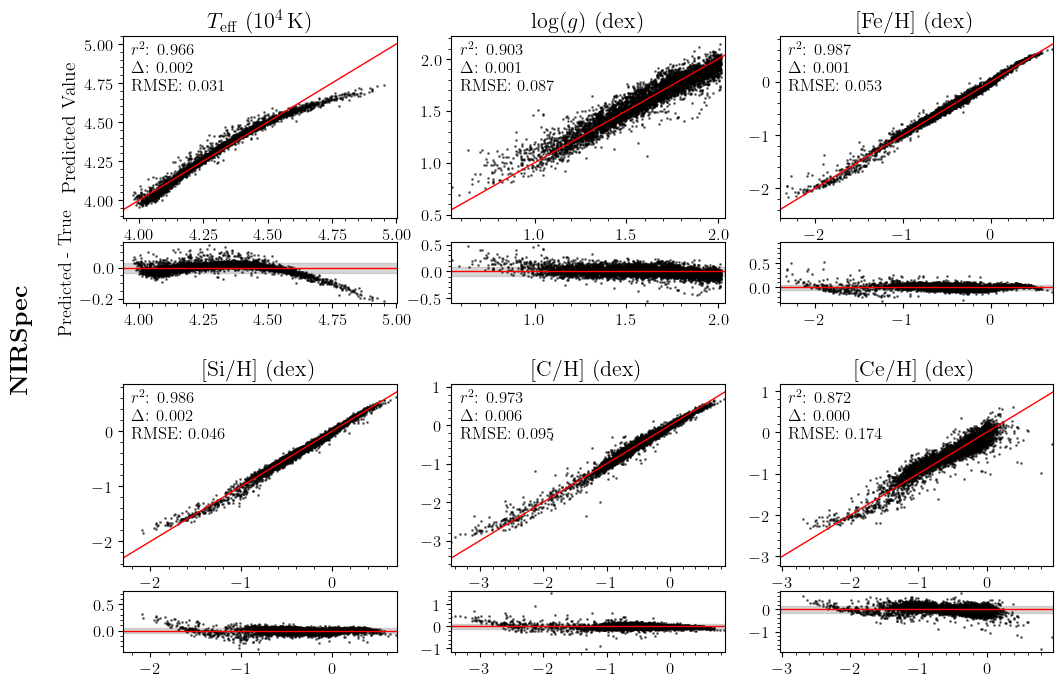

['$T_{\\mathrm{eff}}$',
 '[Si/H]',
 '[O/H]',
 '[Ni/H]',
 '[Ca/H]',
 '[Fe/H]',
 '[Mg/H]',
 '[Ti/H]',
 '[Mn/H]',
 '$\\log(g)$',
 '[Co/H]',
 '[C/H]',
 '[S/H]',
 '[Al/H]',
 '[Cr/H]',
 '[N/H]',
 '[K/H]',
 '[V/H]',
 '[Na/H]',
 '[Ce/H]']

In [38]:
plot_residuals(
    jwst_true, 
    test_j_preds, 
    label_names, 
    "NIRSpec"
)


Metrics for APOGEE:
                  Label      RMSE       R^2      Bias
0   $T_{\mathrm{eff}}$  0.027237  0.974462  0.000027
1            $\log(g)$  0.092937  0.889897  0.004830
2                [C/H]  0.106769  0.966333  0.003352
3                [N/H]  0.107462  0.945714  0.000128
4                [O/H]  0.071782  0.965681  0.000340
5               [Na/H]  0.175818  0.894323  0.004318
6               [Mg/H]  0.077661  0.962590  0.003056
7               [Al/H]  0.119918  0.937862  0.003924
8               [Si/H]  0.067784  0.968585  0.003112
9                [S/H]  0.106038  0.900268  0.003566
10               [K/H]  0.142201  0.886358  0.002744
11              [Ca/H]  0.069139  0.966762  0.002774
12              [Ti/H]  0.094814  0.967132  0.005107
13               [V/H]  0.155412  0.892302  0.002289
14              [Cr/H]  0.111329  0.955137  0.003917
15              [Mn/H]  0.089256  0.978370  0.001331
16              [Fe/H]  0.061921  0.982202  0.003392
17              [Co/H]  

/tmp/ipykernel_1893712/2461516130.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


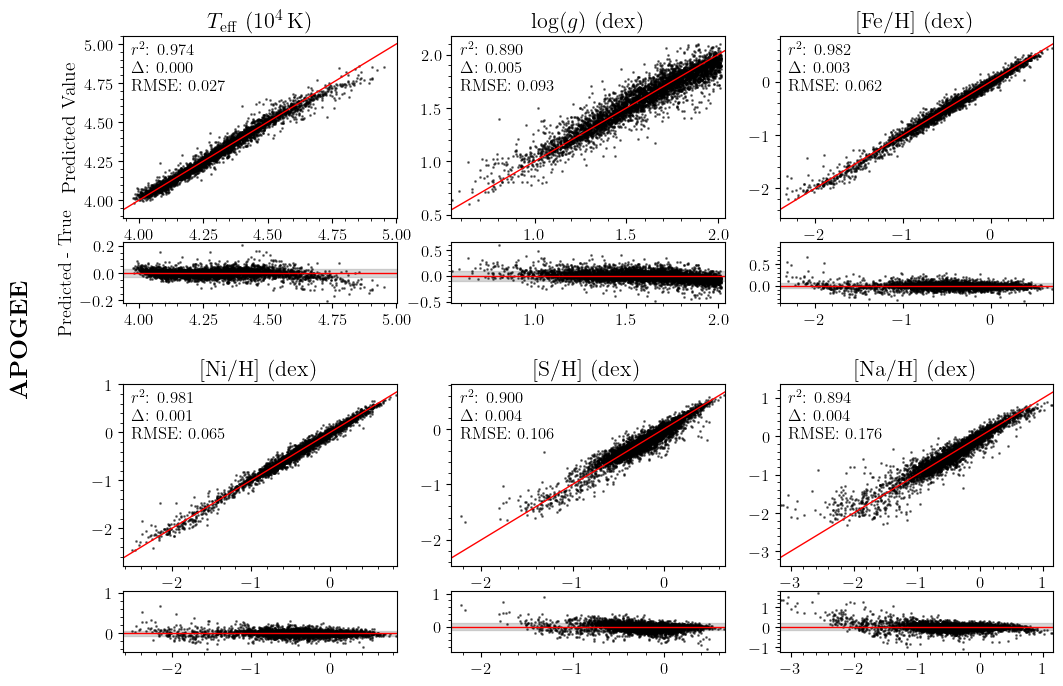

['$T_{\\mathrm{eff}}$',
 '[Fe/H]',
 '[Ni/H]',
 '[Si/H]',
 '[Ca/H]',
 '[O/H]',
 '[Mg/H]',
 '[Mn/H]',
 '$\\log(g)$',
 '[Ti/H]',
 '[Co/H]',
 '[S/H]',
 '[C/H]',
 '[N/H]',
 '[Cr/H]',
 '[Al/H]',
 '[K/H]',
 '[Ce/H]',
 '[V/H]',
 '[Na/H]']

In [39]:
plot_residuals(
    apogee_true, 
    test_a_preds, 
    label_names,
    "APOGEE"
)


Metrics for StarCLIP CNN Baseline:
                  Label      RMSE       R^2      Bias
0   $T_{\mathrm{eff}}$  0.013531  0.993973  0.000243
1            $\log(g)$  0.064243  0.948008  0.001101
2                [C/H]  0.073547  0.984805  0.000199
3                [N/H]  0.077076  0.973187  0.000182
4                [O/H]  0.040125  0.989774  0.000555
5               [Na/H]  0.145389  0.930950  0.004376
6               [Mg/H]  0.042229  0.989557  0.000314
7               [Al/H]  0.078271  0.974449  0.000848
8               [Si/H]  0.035609  0.991795  0.001154
9                [S/H]  0.091627  0.931399  0.002092
10               [K/H]  0.121126  0.920585  0.001624
11              [Ca/H]  0.041107  0.988760  0.000013
12              [Ti/H]  0.052594  0.990397  0.000425
13               [V/H]  0.130217  0.923490  0.001654
14              [Cr/H]  0.093283  0.970395  0.003017
15              [Mn/H]  0.051424  0.993141  0.001283
16              [Fe/H]  0.030535  0.995842  0.000018
17       

/tmp/ipykernel_1893712/2461516130.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


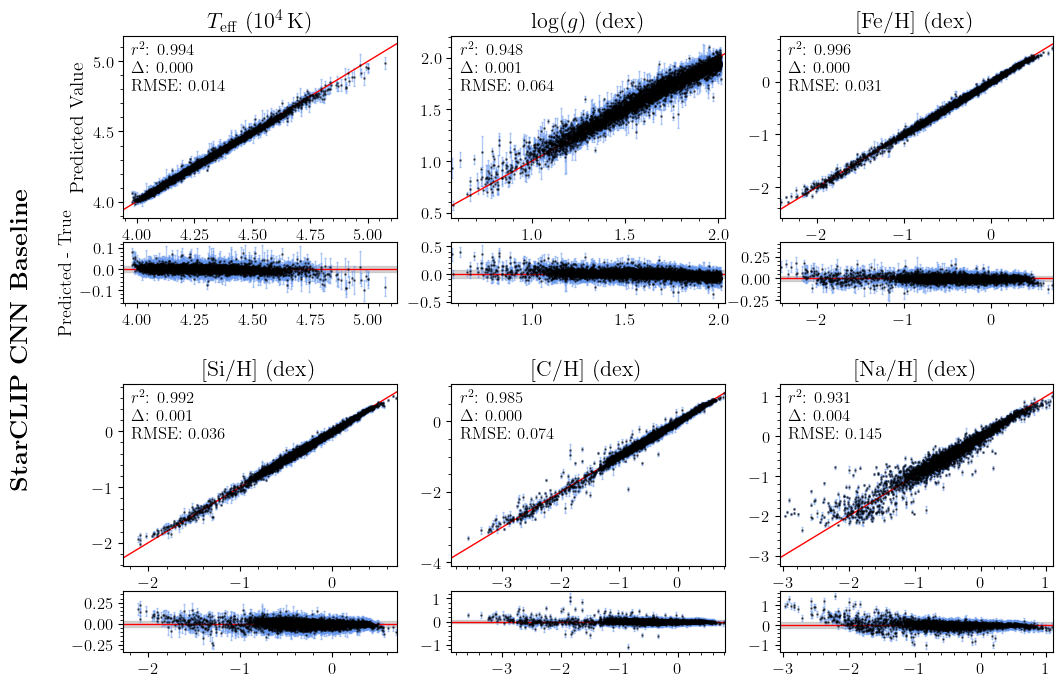

['$T_{\\mathrm{eff}}$',
 '[Fe/H]',
 '[Si/H]',
 '[Ni/H]',
 '[O/H]',
 '[Ca/H]',
 '[Mg/H]',
 '[Mn/H]',
 '[Ti/H]',
 '$\\log(g)$',
 '[C/H]',
 '[N/H]',
 '[Al/H]',
 '[S/H]',
 '[Co/H]',
 '[Cr/H]',
 '[K/H]',
 '[V/H]',
 '[Ce/H]',
 '[Na/H]']

In [40]:
plot_residuals(
    aug_jwst_true,
    test_aug_preds,
    label_names,
    model_name="StarCLIP CNN Baseline",
    apply_mean_aggregation=True,
    custom_labels=["[Si/H]", "[C/H]", "[Na/H]"]
)


Metrics for MockStarCLIP CNN Baseline:
                  Label      RMSE       R^2      Bias
0   $T_{\mathrm{eff}}$  0.031553  0.967587  0.005648
1            $\log(g)$  0.089109  0.900712  0.001847
2                [C/H]  0.082595  0.980881  0.006818
3                [N/H]  0.082215  0.969529  0.004779
4                [O/H]  0.053964  0.981319  0.005954
5               [Na/H]  0.155113  0.920535  0.019496
6               [Mg/H]  0.051010  0.984619  0.005526
7               [Al/H]  0.088282  0.967666  0.010537
8               [Si/H]  0.045896  0.986252  0.003808
9                [S/H]  0.081928  0.943795  0.005926
10               [K/H]  0.097458  0.947922  0.007079
11              [Ca/H]  0.048124  0.984532  0.003764
12              [Ti/H]  0.065309  0.985046  0.001891
13               [V/H]  0.135625  0.919038  0.015953
14              [Cr/H]  0.106364  0.960874  0.015206
15              [Mn/H]  0.064197  0.989289  0.004482
16              [Fe/H]  0.044577  0.991146  0.000892
17   

/tmp/ipykernel_1893712/2461516130.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


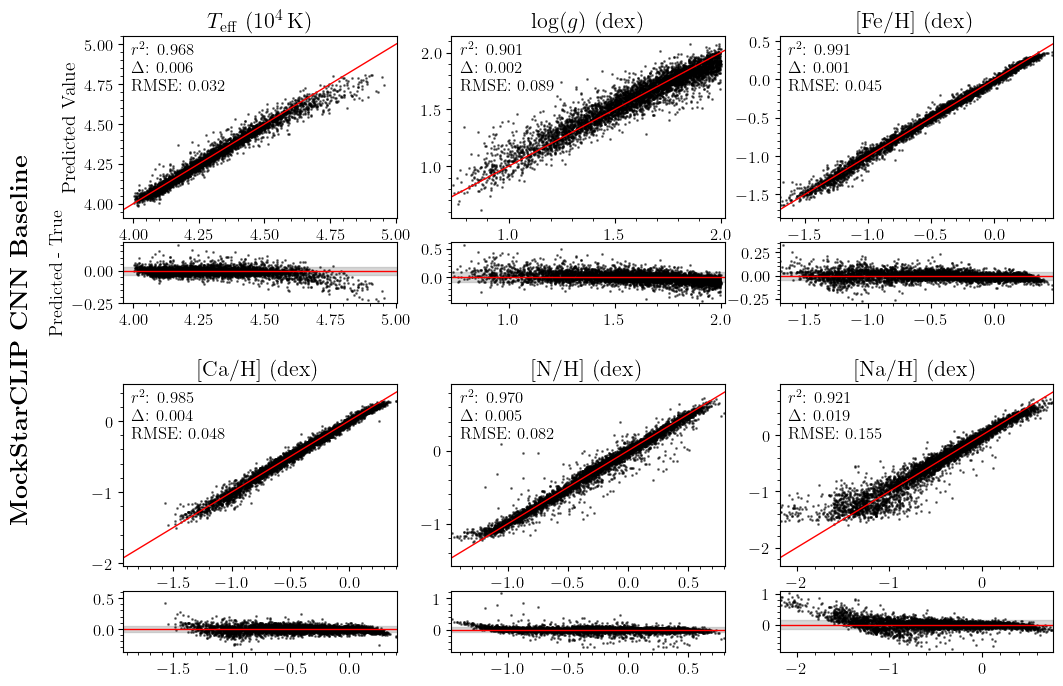

['$T_{\\mathrm{eff}}$',
 '[Fe/H]',
 '[Si/H]',
 '[Ni/H]',
 '[Ca/H]',
 '[Mg/H]',
 '[O/H]',
 '[Mn/H]',
 '[Ti/H]',
 '[S/H]',
 '[N/H]',
 '[C/H]',
 '[Al/H]',
 '$\\log(g)$',
 '[K/H]',
 '[Co/H]',
 '[Cr/H]',
 '[Ce/H]',
 '[V/H]',
 '[Na/H]']

In [41]:
plot_residuals(
    mock_jwst_true,
    test_mock_preds,
    label_names,
    model_name="MockStarCLIP CNN Baseline",
    custom_labels=["[Ca/H]", "[N/H]", "[Na/H]"]
)

## **5. References** <a id="refs"></a>
**Literature**  
Fabbro, S. (2018). *An application of deep learning in the analysis of stellar spectra*. *Monthly Notices of the Royal Astronomical Society*, 475(3), 2978–2993. [https://doi.org/10.1093/mnras/stx3298](https://doi.org/10.1093/mnras/stx3298)

**Code** 
[astroai/starnet: 4_Train_Model_pytorch.ipynb](https://github.com/astroai/starnet/blob/master/4_Train_Model_pytorch.ipynb)